In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib
import matplotlib.pyplot as plt
from scipy.misc import imresize, imrotate
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input, InceptionV3
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
import keras.backend as K
from keras import models
from keras.callbacks import ModelCheckpoint
from time import gmtime, strftime
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib

root_dir = os.path.abspath('..')
%matplotlib inline

Using TensorFlow backend.


In [2]:
def fetch_data(base_dir,num_subjects,mode='two_class'):
    '''Load in simulated data and motion files.'''
    subject_list = os.listdir((os.path.join(base_dir)))
    subject_list = [item for item in subject_list if item.startswith('.') == False] #Filter .DS_STORE
    subject_list = sorted(subject_list) #sort in numerical order to make OS independent
    counter = 0
    X = np.zeros((108*num_subjects,72,86,55))
    y = np.zeros(108*num_subjects)
    X_subject = np.zeros((72,86,55,108))
    y_subject = np.zeros(108)
    for subject_index, subject_number in enumerate(subject_list):
        if subject_index < num_subjects:
            data_path = os.path.join(base_dir,subject_number,'data.nii.gz')
            if os.path.isfile(data_path):
                data_header = nib.load(data_path)
                X_subject = data_header.get_data()
                for i in range(108):
                    motion = np.loadtxt(os.path.join(base_dir,subject_number,'motion/motion'+str(i)+'.txt'))
                    y_subject[i] = create_labels(motion, translation_threshold=2.5, rotation_threshold = 2.5,mode=mode)
                start_index = counter*108
                end_index = (counter+1)*108
                X[start_index:end_index,:] = np.moveaxis(X_subject,3,0)
                y[start_index:end_index] = y_subject
                counter += 1
    return X,y

def create_labels(motion, translation_threshold=1, rotation_threshold = 1,mode='two_class'):
    '''Take a POSSUM motion file and decide whether it contains signficant intra-volume movement.'''
    max_motion = np.max(motion[:,1:],axis=0)
    min_motion = np.min(motion[:,1:],axis=0)
    diff_motion = np.abs(max_motion-min_motion)
    diff_motion[:3] = diff_motion[:3]*1000
    diff_motion[3:] = np.rad2deg(diff_motion[3:])
    if mode == 'two_class':
        if np.any( diff_motion[:3] > translation_threshold):
            return 1
        elif np.any(diff_motion[3:] > rotation_threshold):
            return 1
        else:
            return 0
    if mode == 'three_class':
        if np.any( diff_motion[:3] > translation_threshold):
            return 1    
        elif np.any(diff_motion[3:] > rotation_threshold):
            return 1
        elif np.any( diff_motion[:3] > 1):
            return 2    
        elif np.any(diff_motion[3:] > 1):
            return 2
        else:
            return 0
def pad_image(image,pad_max):
    if pad_max == 0:
        return image
    else:
        pad_width = np.array([[pad_max,pad_max],[pad_max,pad_max]])-[image.shape,image.shape]
        pad_width=np.transpose(pad_width)
        pad_width[:,0] = np.floor(pad_width[:,0]/2)
        pad_width[:,1] = np.ceil(pad_width[:,1]/2)
        return np.lib.pad(image,pad_width,'constant',constant_values=(0))
    
def preprocess_data_saggital(X,target_height=299,target_width=299,is_training=False,\
                           flip=False,rotate_z=False,base_slice=36,sample_more_slices=True,\
                           pad_images=False,crop_image=False,rescale=False):
    '''Convert each MR volume to three slices through a single plane, scales the data and resamples
    to 299 by 299 pixels. Optionally performs augmentation.'''   
    #slices = [22,36,50] #Planes to slice
    slices = np.array([base_slice,base_slice,base_slice]) #Planes to slice
    if pad_images == True:
        pad_max = np.max(X.shape[2:]) #Width to pad images to
    else:
        pad_max = 0
    num_volumes = X.shape[0]
    height = X.shape[1]
    width = X.shape[2]
    num_slices = X.shape[3]
    X_preprocessed = np.zeros((num_volumes,target_height,target_width,3))
    if is_training == True:
        for i in range(num_volumes):
            vol = np.copy(np.squeeze(X[i,:]))
            #Flip
            if flip == True:
                if np.random.uniform() > 0.5:
                    vol = np.fliplr(vol)
                if np.random.uniform() > 0.5:
                    vol = np.flip(vol,2)
            #Rotate about z
            if rotate_z == True:
                angle = np.random.randint(-20,20)
                for slice_num in range(num_slices):
                    vol[:,:,slice_num] = imrotate(vol[:,:,slice_num],angle,interp='bilinear')
            #Sample different slice in plane
            if sample_more_slices == True:
                slices_new = slices + np.random.randint(-5,5)
            else:
                slices_new = slices
            #Crop
            if crop_image == True:
                image_ratio = width / height
                target_image_ratio = target_width / target_height
                crop_vertically = image_ratio < target_image_ratio
                crop_width = width if crop_vertically else int(height * target_image_ratio)
                crop_height = int(width / target_image_ratio) if crop_vertically else height

                # Now let's shrink this bounding box by a random factor (dividing the dimensions by a random number
                # between 1.0 and 1.0 + `max_zoom`.
                max_zoom = 0.8
                resize_factor = np.random.rand() * max_zoom + 1.0
                crop_width = int(crop_width / resize_factor)
                crop_height = int(crop_height / resize_factor)

                # Next, we can select a random location on the image for this bounding box.
                x0 = np.random.randint(0, width - crop_width)
                y0 = np.random.randint(0, height - crop_height)
                x1 = x0 + crop_width
                y1 = y0 + crop_height
            else:
                x0=0;y0=0;x1=width;y1=height
            for j in range(3):
                if (j == 0):
                    X_preprocessed[i,:,:,j] = imresize(pad_image(vol[slices_new[j],y0:y1, x0:x1],pad_max),(target_width,target_height))
                if (j == 1):
                    X_preprocessed[i,:,:,j] = imresize(pad_image(vol[slices_new[j],y0:y1, x0:x1],pad_max),(target_width,target_height))
                if (j == 2):
                    X_preprocessed[i,:,:,j] = imresize(pad_image(vol[slices_new[j],y0:y1, x0:x1],pad_max),(target_width,target_height))     
                    
    else:
        pad_max = np.max(X.shape[2:]) #Always pad for testing
        for i in range(num_volumes):
            for j in range(3):
                if (j == 0):
                    X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,slices[j],:,:]),pad_max),(target_width,target_height))
                if (j == 1):
                    X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,slices[j],:,:]),pad_max),(target_width,target_height))
                if (j == 2):
                    X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,slices[j],:,:]),pad_max),(target_width,target_height))     
   
    if rescale == True:
        X_preprocessed = X_preprocessed.astype(np.float32)
        X_preprocessed/= 255
        percentile =np.percentile(X_preprocessed,99.9)
        X_preprocessed[X_preprocessed>percentile] = percentile
        X_preprocessed/=percentile
        X_preprocessed -= 0.5
        X_preprocessed *= 2.
    return X_preprocessed

def preprocess_data_coronal(X,target_height=299,target_width=299, base_slice=36,rescale=False,):
    '''Convert each MR volume to three slices through a single plane, scales the data and resamples
    to 299 by 299 pixels. Optionally performs augmentation.'''   
    #slices = [22,36,50] #Planes to slice
    slices = np.array([base_slice,base_slice,base_slice]) #Planes to slice
    pad_max = np.max([X.shape[1],X.shape[3]]) #Width to pad images to
    
    num_volumes = X.shape[0]
    height = X.shape[1]
    width = X.shape[3]
    num_slices = X.shape[2]
    X_preprocessed = np.zeros((num_volumes,target_height,target_width,3))

    for i in range(num_volumes):
        for j in range(3):
            if (j == 0):
                X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,:,slices[j],:]),pad_max),(target_width,target_height))
            if (j == 1):
                X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,:,slices[j],:]),pad_max),(target_width,target_height))
            if (j == 2):
                X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,:,slices[j],:]),pad_max),(target_width,target_height))     
   
    if rescale == True:
        X_preprocessed = X_preprocessed.astype(np.float32)
        X_preprocessed/= 255
        percentile =np.percentile(X_preprocessed,99.9)
        X_preprocessed[X_preprocessed>percentile] = percentile
        X_preprocessed/=percentile
        X_preprocessed -= 0.5
        X_preprocessed *= 2.
    return X_preprocessed

def preprocess_input_scaling(x):
        x=x.astype(np.float32)
        x /= 255.
        percentile =np.percentile(x,99.9)
        x[x>percentile] = percentile
        x/=percentile
        x -= 0.5
        x *= 2.
        return x

In [11]:
mode='three_class'
#view = 'coronal'
view = 'saggital'

X, y = fetch_data(os.path.join(root_dir,'data/sims-moremotion'),10,mode=mode)
print('Volumes with no motion:',np.sum(y==0))
print('Volumes with severe motion:',np.sum(y==1))
print('Volumes with moderate motion:',np.sum(y==2))


num_vols = 108
num_train = 8
num_test = 2
slices_to_extract = [20,36,52]

X_train = np.zeros((num_vols*num_train*len(slices_to_extract),299,299,3))
X_test = np.zeros((num_vols*num_test*len(slices_to_extract),299,299,3))
y_train = np.zeros((num_vols*num_train*len(slices_to_extract)))
y_test = np.zeros((num_vols*num_test*len(slices_to_extract)))

for slice_num, slice_indx in enumerate(slices_to_extract):
    start_indx_train = slice_num * num_vols*num_train
    end_indx_train = (slice_num+1) * num_vols*num_train
    start_indx_test = slice_num * num_vols*num_test
    end_indx_test = (slice_num+1) * num_vols*num_test
    if view == 'coronal':
        X_preprocessed = preprocess_data_coronal(X,base_slice=slice_indx)
    elif view == 'saggital':
        X_preprocessed = preprocess_data_saggital(X,base_slice=slice_indx)
    else:
        print('View not recognised')

    X_train[start_indx_train:end_indx_train,:] = X_preprocessed[:num_vols*num_train]
    X_test[start_indx_test:end_indx_test,:] = X_preprocessed[num_vols*num_train:]
    y_train[start_indx_train:end_indx_train]= y[:num_vols*num_train]
    y_test[start_indx_test:end_indx_test]=y[num_vols*num_train:]

if mode=='three_class':
    X_train = np.delete(X_train,np.where(y_train==2),0)
    y_train = np.delete(y_train,np.where(y_train==2),0)
    X_test = np.delete(X_test,np.where(y_test==2),0)
    y_test = np.delete(y_test,np.where(y_test==2),0)
    
#Clear memory
del X,y, X_preprocessed

Volumes with no motion: 716
Volumes with severe motion: 280
Volumes with moderate motion: 84


In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2391, 299, 299, 3)
(2391,)
(597, 299, 299, 3)
(597,)


195
1.0


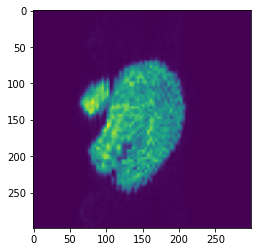

In [12]:
y_train_motion =np.where(y_train==1)[0]

index=50
print(y_train_motion[index])
plt.imshow(X_train[y_train_motion[index],:,:,0])
print(y_train[y_train_motion[index]])

In [13]:
train_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-6,
    rotation_range=0.,
    width_shift_range=0.,
    height_shift_range=0.,
    shear_range=0.0,
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=preprocess_input_scaling,
    data_format='channels_last')

validation_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-6,
    rotation_range=0.,
    width_shift_range=0.,
    height_shift_range=0.,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=preprocess_input_scaling,
    data_format='channels_last',)

train_batch_size = 54
validation_batch_size = 54
train_examples = X_train.shape[0]
validation_examples = X_test.shape[0]
train_data = train_generator.flow(X_train,to_categorical(y_train,2),batch_size=train_batch_size,shuffle=True)
validation_data = validation_generator.flow(X_test,to_categorical(y_test,2),batch_size=validation_batch_size,shuffle=False)


#     ctr = 0
#     for batch in train_data:
#         im = np.squeeze(batch[0][6,:])
#         print(im.shape)
#         plt.imshow(im)
#         ctr += 1
#         if ctr > 0:
#             break

In [14]:
print('Percentage motion-free in train set:',1-np.sum(y_train)/len(y_train))
print('Number with motion in train set:',np.sum(y_train))

print('Percentage motion-free in test set:',1-np.sum(y_test)/len(y_test))
print('Number with motion in test set:',np.sum(y_test))

Percentage motion-free in train set: 0.7252195734
Number with motion in train set: 657.0
Percentage motion-free in test set: 0.693467336683
Number with motion in test set: 183.0


In [15]:
#Set up inception v3 for transfer learning
base_model = InceptionV3(weights='imagenet',include_top=False)

In [16]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(16,activation='relu')(x)
predictions = Dense(2,activation='softmax')(x)


    
model = Model(inputs=base_model.input,outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer='adam',
             loss='binary_crossentropy',
                 metrics=['accuracy'])

In [17]:
now = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
filename = 'keras_logs/'+now+'.epoch{epoch:02d}-lossval{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath=filename,
                            period=10)

train_steps_per_epoch = train_examples/train_batch_size
validation_steps_per_epoch = validation_examples/validation_batch_size
print(train_steps_per_epoch)
print(validation_steps_per_epoch)
num_epochs = 30




print('Model name:','keras_logs/'+now)
history = model.fit_generator(generator = train_data,
                           steps_per_epoch=train_steps_per_epoch,
                           epochs = num_epochs,
                           validation_data = validation_data,
                           validation_steps = validation_steps_per_epoch,
                           class_weight=[1,5],
                            callbacks=[checkpoint])

validation_data = validation_generator.flow(X_test,to_categorical(y_test,2),batch_size=validation_batch_size,shuffle=False)
y_pred = model.predict_generator(validation_data,validation_steps_per_epoch)[:,1] > 0.5
print(confusion_matrix(y_test,y_pred))

44.27777777777778
11.055555555555555
Model name: keras_logs/2017-10-13-13-50-06
Epoch 1/30
45/44 [==============================] - 50s - loss: 0.5458 - acc: 0.7107 - val_loss: 0.5282 - val_acc: 0.6935
Epoch 2/30
45/44 [==============================] - 49s - loss: 0.3785 - acc: 0.8151 - val_loss: 0.4233 - val_acc: 0.7739
Epoch 3/30
45/44 [==============================] - 49s - loss: 0.3305 - acc: 0.8989 - val_loss: 0.4255 - val_acc: 0.7856
Epoch 4/30
45/44 [==============================] - 49s - loss: 0.2994 - acc: 0.9226 - val_loss: 0.3840 - val_acc: 0.8409
Epoch 5/30
45/44 [==============================] - 49s - loss: 0.2752 - acc: 0.9345 - val_loss: 0.3491 - val_acc: 0.9263
Epoch 6/30
45/44 [==============================] - 49s - loss: 0.2612 - acc: 0.9440 - val_loss: 0.3361 - val_acc: 0.9079
Epoch 7/30
45/44 [==============================] - 49s - loss: 0.2539 - acc: 0.9470 - val_loss: 0.3374 - val_acc: 0.9028
Epoch 8/30
45/44 [==============================] - 49s - loss: 0.

In [ ]:
#Get predictions for many slices of the train set
validation_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-6,
    rotation_range=0.,
    width_shift_range=0.,
    height_shift_range=0.,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=preprocess_input_scaling,
    data_format='channels_last',)

model_coronal =   models.load_model('keras_logs/coronal_model.hdf5')
model_saggital =   models.load_model('keras_logs/saggital_model.hdf5')

#Free up some mem
#del X_train, X_test
num_slices = 30

num_volumes = 648
X, y = fetch_data(os.path.join(root_dir,'data/sims-moremotion'),8)
y_train = y[:num_volumes]
X_train = X[:num_volumes,:,:,:]
del X, y

validation_batch_size = 54
num_generator_steps = int(num_volumes/validation_batch_size)

model_predictions_coronal_train = np.zeros((num_volumes,num_slices))
model_predictions_saggital_train = np.zeros((num_volumes,num_slices))

for i in range(num_slices):
    #coronal
    X_test_slice = preprocess_data_coronal(X_train,base_slice = 25+i)  
    #Redefine validation generator to reset
    validation_data_for_testing = validation_generator.flow(X_test_slice,y_train,batch_size=validation_batch_size,shuffle=False)
    model_predictions_coronal_train[:,i] = model_coronal.predict_generator(validation_data_for_testing,num_generator_steps)[:,1]
    del X_test_slice
    
    #saggital
    X_test_slice = preprocess_data_saggital(X_train,base_slice = 25+i)  
    #Redefine validation generator to reset
    validation_data_for_testing = validation_generator.flow(X_test_slice,y_train,batch_size=validation_batch_size,shuffle=False)
    model_predictions_saggital_train[:,i] = model_saggital.predict_generator(validation_data_for_testing,num_generator_steps)[:,1]
    del X_test_slice
    print('Slices complete:',i)

In [ ]:
#Train classifier on predictions and gt

svm_classifier = SVC(kernel='linear')
predictions_combined_train = np.concatenate((model_predictions_coronal_train,model_predictions_saggital_train),axis=1)
#predictions_combined_train = model_predictions_coronal_train
svm_classifier.fit(predictions_combined_train,y_train)
y_pred = svm_classifier.predict(predictions_combined_train)
print(accuracy_score(y_train,y_pred))
print(confusion_matrix(y_train,y_pred))


rf_classifier = RandomForestClassifier(n_estimators=3)
rf_classifier.fit(predictions_combined_train,y_train)
y_pred_rf = rf_classifier.predict(predictions_combined_train)
print(accuracy_score(y_train,y_pred_rf))
print(confusion_matrix(y_train,y_pred_rf))

#Save relevant files

np.save('misc_files/predictions_combined_train',predictions_combined_train)
np.save('misc_files/y_train',y_train)
joblib.dump(svm_classifier, 'misc_files/svm_classifier.pkl') 
joblib.dump(rf_classifier, 'misc_files/rf_classifier.pkl') 

In [28]:
#Test on many slices of validation set
from sklearn.metrics import confusion_matrix, accuracy_score
from keras import models
#from sklearn.model_selection import accuracy

#model_coronal =   models.load_model('keras_logs/coronal_model.hdf5')
#model_saggital=   models.load_model('keras_logs/saggital_model.hdf5')
model_coronal =   model#models.load_model('keras_logs/2017-10-05-14-39-37.epoch29-lossval0.29.hdf5')
#model_saggital =   models.load_model('keras_logs/2017-10-05-13-58-21.epoch29-lossval0.20.hdf5')


X, y = fetch_data(os.path.join(root_dir,'data/sims-moremotion'),10)
num_volumes = 216
y_val = y[864:]
X_val = X[864:,:,:,:]
print(y_val.shape)
del X, y

num_slices = 30
validation_batch_size = 54
num_generator_steps = int(num_volumes/validation_batch_size)

model_predictions_coronal_val = np.zeros((num_volumes,num_slices))
model_predictions_saggital_val = np.zeros((num_volumes,num_slices))

for i in range(num_slices):
    #coronal
    X_val_slice = preprocess_data_coronal(X_val,base_slice = 25+i)  
    #Redefine validation generator to reset
    validation_data_for_testing = validation_generator.flow(X_val_slice,to_categorical(y_val,2),batch_size=validation_batch_size,shuffle=False)
    model_predictions_coronal_val[:,i] = model_coronal.predict_generator(validation_data_for_testing,num_generator_steps)[:,1]
    
#     #saggital
#     X_val_slice = preprocess_data_planar(X_val,base_slice = 25+i)  
#     #Redefine validation generator to reset
#     validation_data_for_testing = validation_generator.flow(X_val_slice,to_categorical(y_val,2),batch_size=validation_batch_size,shuffle=False)
#     model_predictions_saggital_val[:,i] = model_saggital.predict_generator(validation_data_for_testing,num_generator_steps)[:,1]
    print('Slices complete:',i)



(216,)
Slices complete: 0
Slices complete: 1
Slices complete: 2
Slices complete: 3
Slices complete: 4
Slices complete: 5
Slices complete: 6
Slices complete: 7
Slices complete: 8
Slices complete: 9
Slices complete: 10
Slices complete: 11
Slices complete: 12
Slices complete: 13
Slices complete: 14
Slices complete: 15
Slices complete: 16
Slices complete: 17
Slices complete: 18
Slices complete: 19
Slices complete: 20
Slices complete: 21
Slices complete: 22
Slices complete: 23
Slices complete: 24
Slices complete: 25
Slices complete: 26
Slices complete: 27
Slices complete: 28
Slices complete: 29


In [29]:
#predictions_combined_val = np.concatenate((model_predictions_coronal_val,model_predictions_saggital_val),axis=1)
predictions_combined_val=model_predictions_coronal_val

y_pred_val = np.mean(predictions_combined_val,axis=1)>0.5
print(accuracy_score(y_val,y_pred_val))
print(confusion_matrix(y_val,y_pred_val))

# y_pred_val = svm_classifier.predict(predictions_combined_val)
# print(accuracy_score(y_val,y_pred_val))
# print(confusion_matrix(y_val,y_pred_val))
# y_pred_val_rf = rf_classifier.predict(predictions_combined_val)
# print(accuracy_score(y_val,y_pred_val_rf))
# print(confusion_matrix(y_val,y_pred_val_rf))

#Save relevant files
#from sklearn.externals import joblib
#np.save('misc_files/predictions_combined_val',predictions_combined_val)
#np.save('misc_files/y_val',y_val)

0.981481481481
[[154   1]
 [  3  58]]


# Visualise 

In [31]:
#Load back in results
#y_predictions_combined = np.load('misc_files/predictions_combined_val.npy')
#y_val = np.load('misc_files/y_val.npy')
#svm_classifier = joblib.load('misc_files/svm_classifier.pkl') 
#y_pred_val = svm_classifier.predict(y_predictions_combined)
#y_pred_val = np.mean(y_predictions_combined,axis=1) > 0.5 
print(confusion_matrix(y_val,y_pred_val))


[[154   1]
 [  3  58]]


In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix
from matplotlib import animation
from matplotlib import animation, rc
from IPython.display import HTML


ind_true_pos = [indx for indx,y in enumerate(y_val) if (y_val[indx] == 1) and (y_pred_val[indx] == 1) ]
ind_true_neg = [indx for indx,y in enumerate(y_val) if (y_val[indx] == 0) and (y_pred_val[indx] == 0) ]
ind_false_neg = [indx for indx,y in enumerate(y_val) if (y_val[indx] == 1) and (y_pred_val[indx] == 0) ]
ind_false_pos = [indx for indx,y in enumerate(y_val) if (y_val[indx] == 0) and (y_pred_val[indx] == 1) ]

1.0
0.999888038635


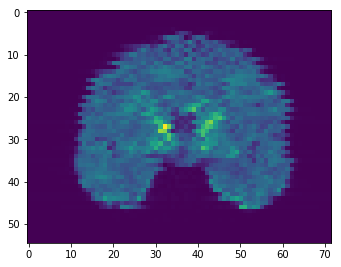

In [61]:
#Static plot sof results
plt.figure(figsize=(12,12))
index =35
slice_=53
index2 = ind_true_pos[index]
plt.subplot(1,2,1)
plt.imshow(np.rot90(X_val[index2,:,slice_,:]))
print(y_val[index2])
print(np.mean(predictions_combined_val[index2,:]))

In [ ]:
#Animated plot of confusion-matrix
#X, y = fetch_data(os.path.join(root_dir,'data/sims'),8)
X_test_preprocessed = preprocess_data_planar(X[648:,:,:,:])
#del X, y

X_test_preprocessed_plot = X_test_preprocessed.astype(np.float32)/255
#X_test_preprocessed_plot += 0.5

fig=plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

image1 = ax1.imshow(np.zeros((X_test_preprocessed_plot.shape[1],X_test_preprocessed_plot.shape[2],3))); ax1.axis('off')
image2 = ax2.imshow(np.zeros((X_test_preprocessed_plot.shape[1],X_test_preprocessed_plot.shape[2],3))); ax2.axis('off')
image3 = ax3.imshow(np.zeros((X_test_preprocessed_plot.shape[1],X_test_preprocessed_plot.shape[2],3))); ax3.axis('off')
image4 = ax4.imshow(np.zeros((X_test_preprocessed_plot.shape[1],X_test_preprocessed_plot.shape[2],3))); ax4.axis('off')
fig.text(0.5, 0.94, 'Predictions', ha='center',weight='bold')
fig.text(0.06, 0.5, 'Actual', ha='center',weight='bold')
fig.text(0.08, 0.7, 'False', ha='center')
fig.text(0.08, 0.3, 'True', ha='center')
fig.text(0.32, 0.9, 'False', ha='center')
fig.text(0.7, 0.9, 'True', ha='center')
fig.text(0.47, 0.52, str(len(ind_true_neg)), ha='center',color='white')
fig.text(0.55, 0.52, str(len(ind_false_pos)), ha='center',color='white')
fig.text(0.47, 0.45, str(len(ind_false_neg)), ha='center',color='white')
fig.text(0.55, 0.45, str(len(ind_true_pos)), ha='center',color='white')

matplotlib.rcParams.update({'font.size': 20})
fig.subplots_adjust(hspace=0.03, wspace=0.02)
plt.close()

def init():
    image1.set_data(np.zeros((X_test_preprocessed_plot.shape[1],X_test_preprocessed_plot.shape[2]))); 
    image2.set_data(np.zeros((X_test_preprocessed_plot.shape[1],X_test_preprocessed_plot.shape[2])))
    image3.set_data(np.zeros((X_test_preprocessed_plot.shape[1],X_test_preprocessed_plot.shape[2])))
    image4.set_data(np.zeros((X_test_preprocessed_plot.shape[1],X_test_preprocessed_plot.shape[2])))
    
    return image1,image2,image3,image4,

def animate(i):
    image1.set_data(np.rot90(X_test_preprocessed_plot[ind_true_neg[i % len(ind_true_neg)],:]))
    image2.set_data(np.rot90(X_test_preprocessed_plot[ind_false_pos[i % len(ind_false_pos)],:]))
    image3.set_data(np.rot90(X_test_preprocessed_plot[ind_false_neg[i % len(ind_false_neg)],:]))
    image4.set_data(np.rot90(X_test_preprocessed_plot[ind_true_pos[i % len(ind_true_pos)],:]))
    return image1,image2,image3,image4,

anim = animation.FuncAnimation(fig,animate,init_func=init,frames=40,interval=200,blit=True)
mywriter = animation.FFMpegWriter()
HTML(anim.to_html5_video())

In [ ]:
#import matplotlib
#import matplotlib.pyplot as plt
print(y_test)
plt.plot(np.linspace(25,54,30),model_predictions[n])
plt.title('True:'+str(y_test[n])+' Predicted:'+str(y_pred[n]))

In [ ]:
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))

In [ ]:
def plot_training(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')

  plt.figure()
  plt.plot(epochs, loss, 'r.')
  plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
  plt.show()

plot_training(history)

In [ ]:
#Look at memory usage of all items in notebook
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)